### **Set Up**

In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
travel_train = pd.read_csv('/content/drive/MyDrive/Classes/MIT/ADSP/Hackathon/Train dataset/Traveldata_train_(2).csv')
survey_train = pd.read_csv('/content/drive/MyDrive/Classes/MIT/ADSP/Hackathon/Train dataset/Surveydata_train_(2).csv')

travel_test = pd.read_csv('/content/drive/MyDrive/Classes/MIT/ADSP/Hackathon/Test dataset/Traveldata_test_(2).csv')
survey_test = pd.read_csv('/content/drive/MyDrive/Classes/MIT/ADSP/Hackathon/Test dataset/Surveydata_test_(2).csv')

In [5]:
train_data = pd.merge(travel_train, survey_train, on='ID')
test_data = pd.merge(travel_test, survey_test, on='ID')

### **EDA / Feature Engineering**

In [6]:
train_data.nunique()

,0
ID,94379
Gender,2
Customer_Type,2
Age,75
Type_Travel,2
Travel_Class,2
Travel_Distance,5210
Departure_Delay_in_Mins,437
Arrival_Delay_in_Mins,434
Overall_Experience,2


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

In [8]:
categorical = ['Gender', 'Customer_Type', 'Type_Travel', 'Travel_Class', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding']
numerical = ['Age', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Overall_Experience']

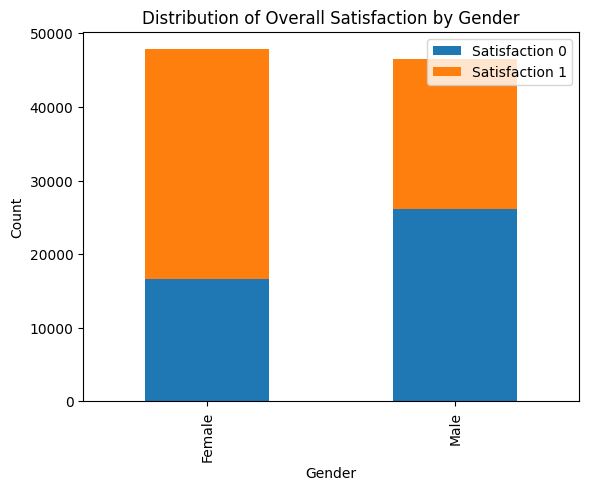

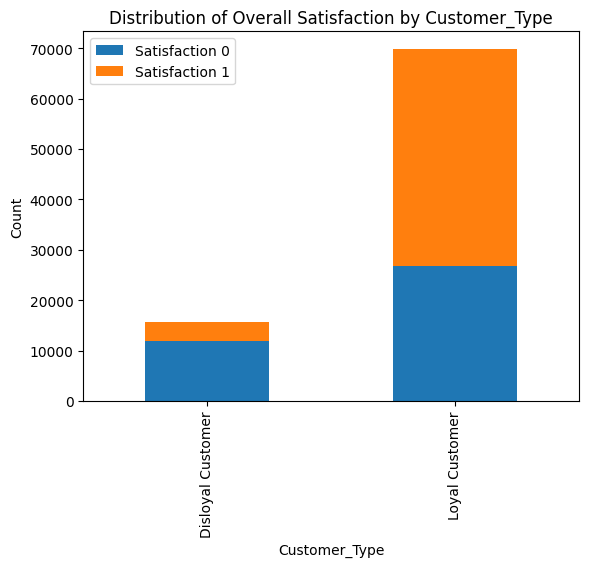

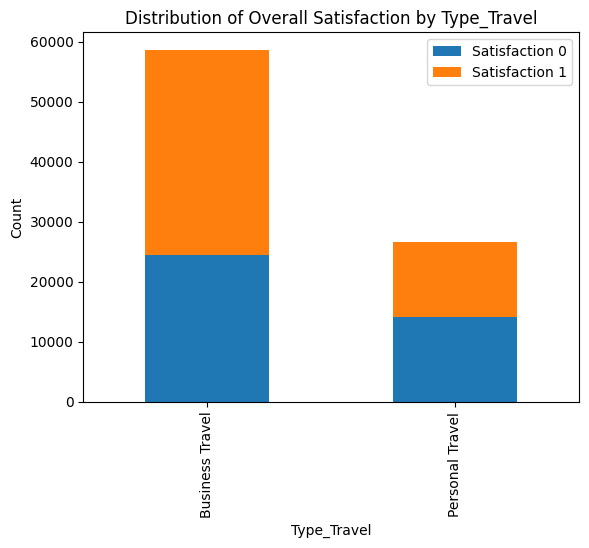

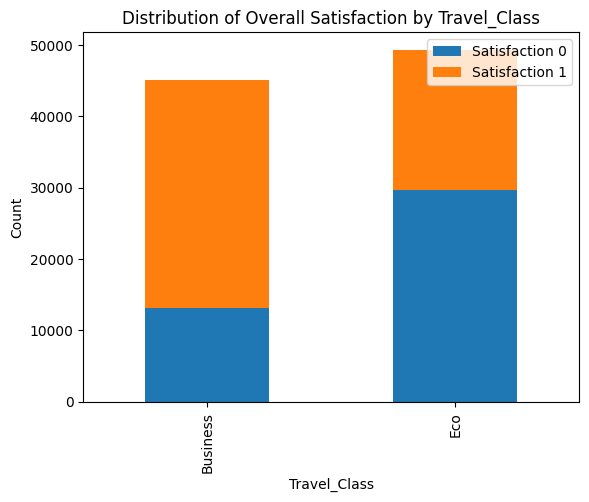

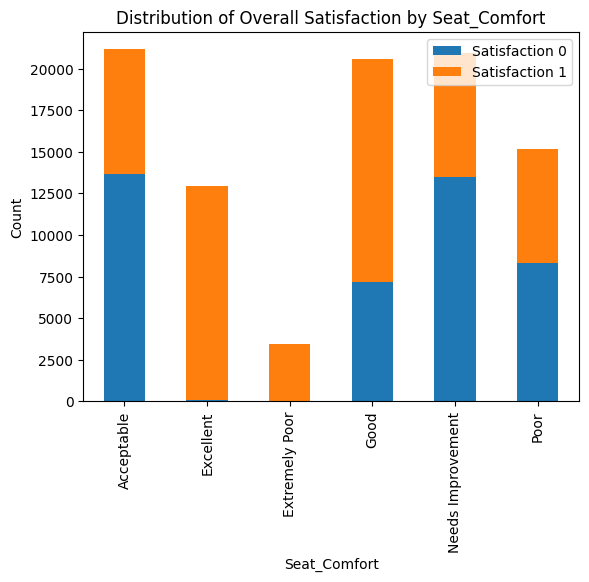

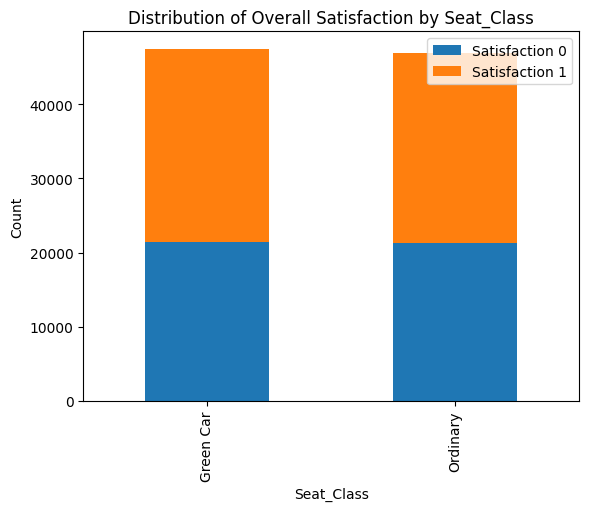

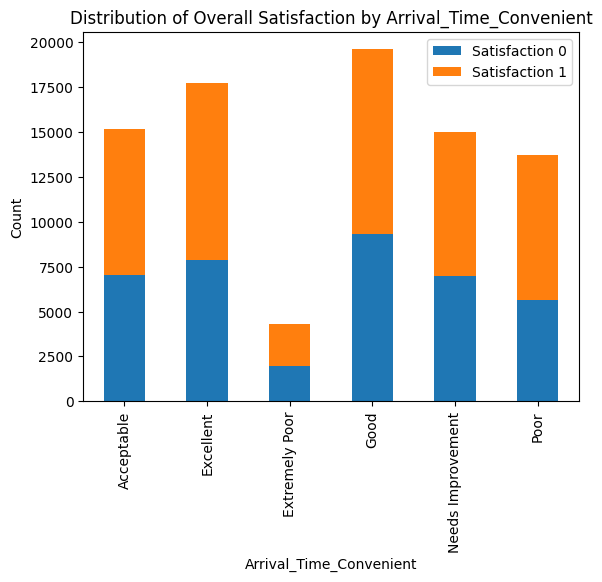

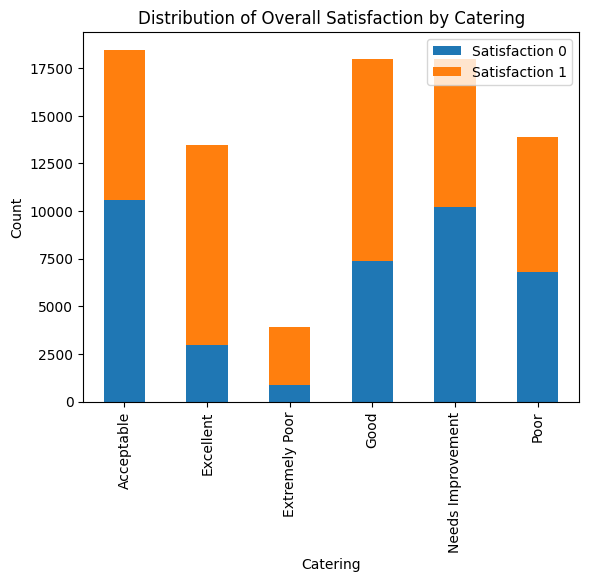

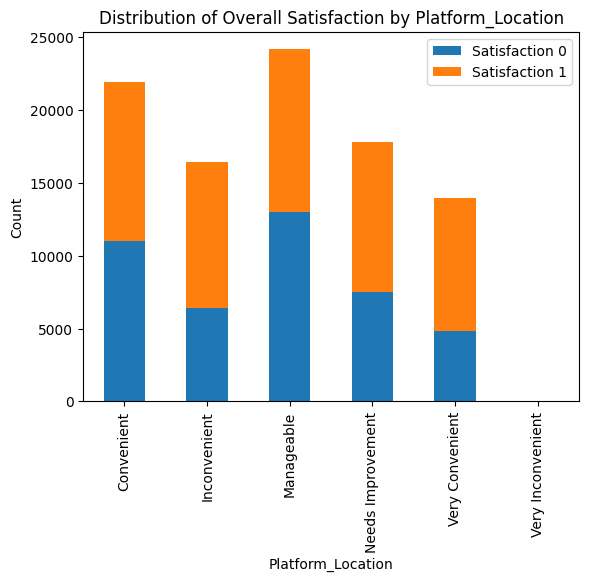

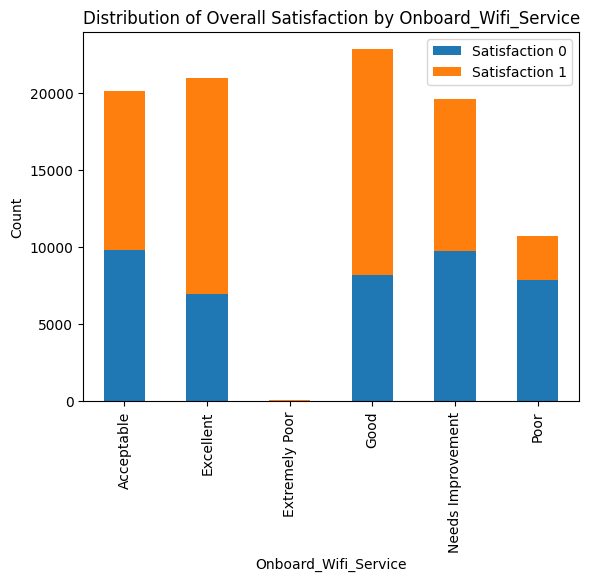

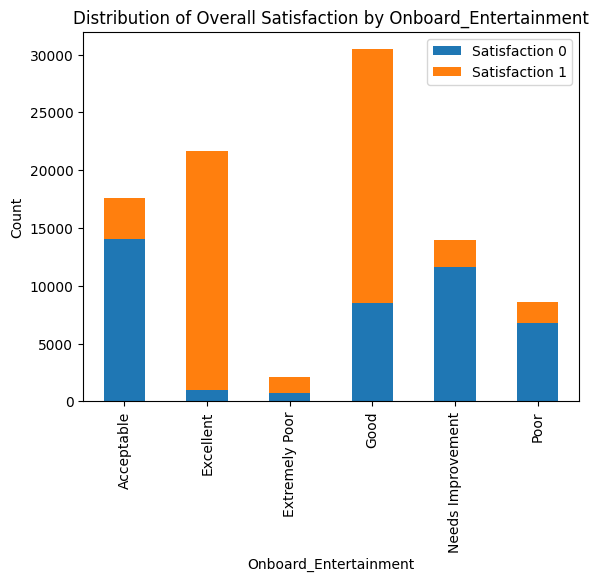

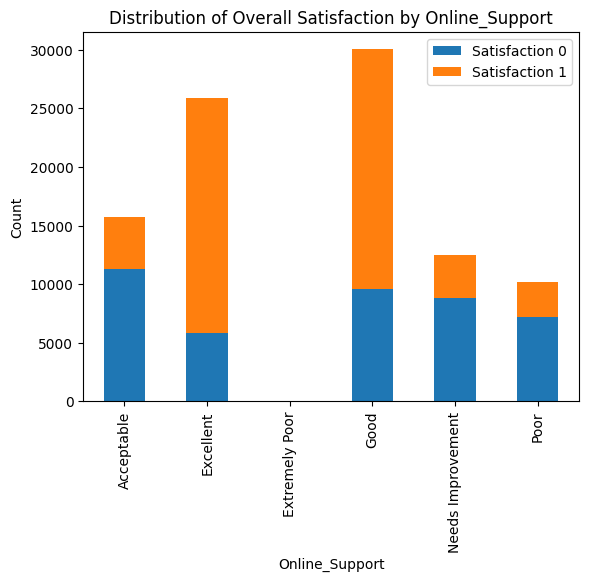

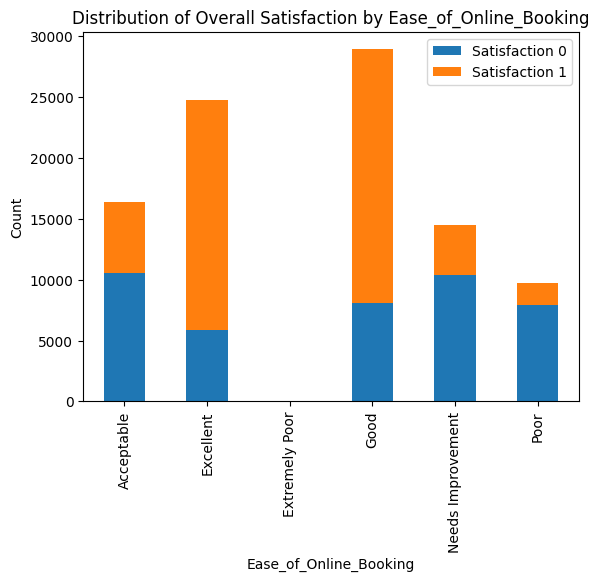

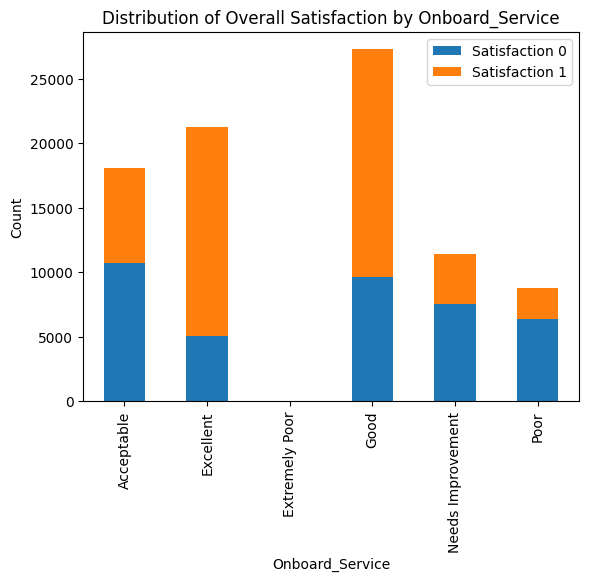

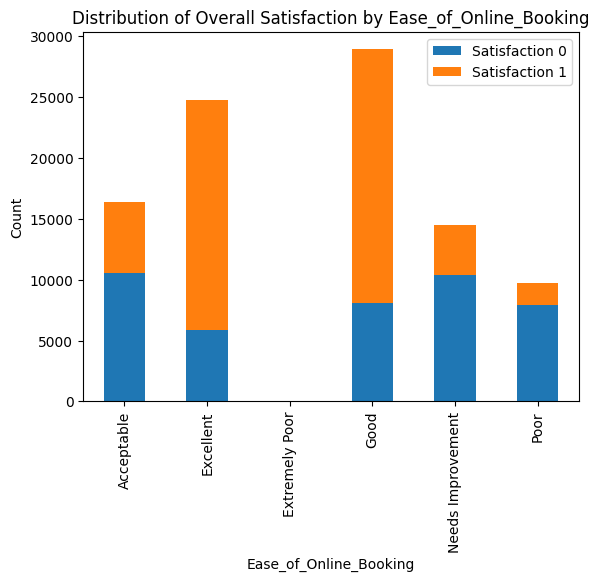

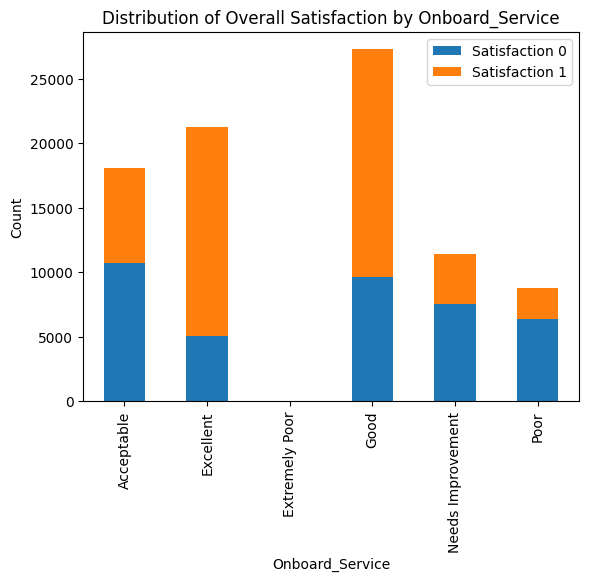

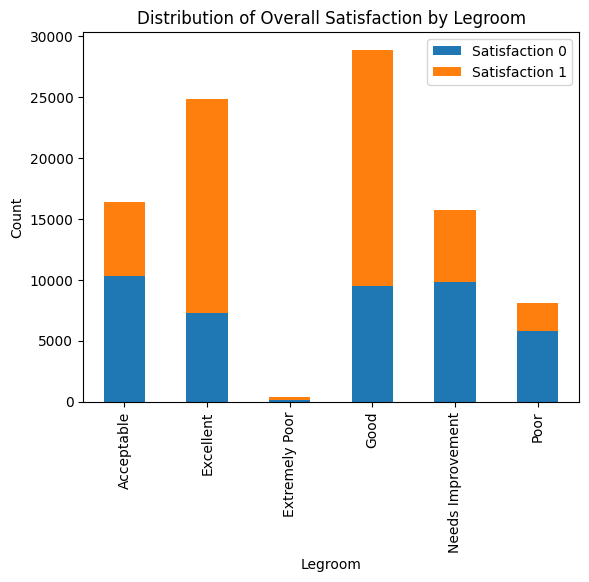

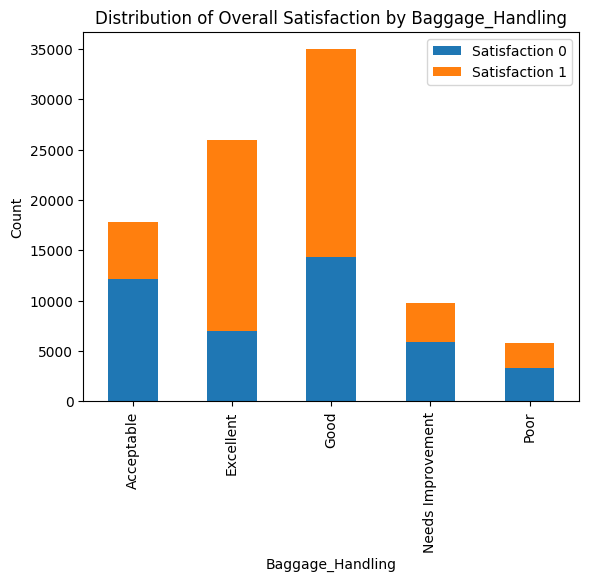

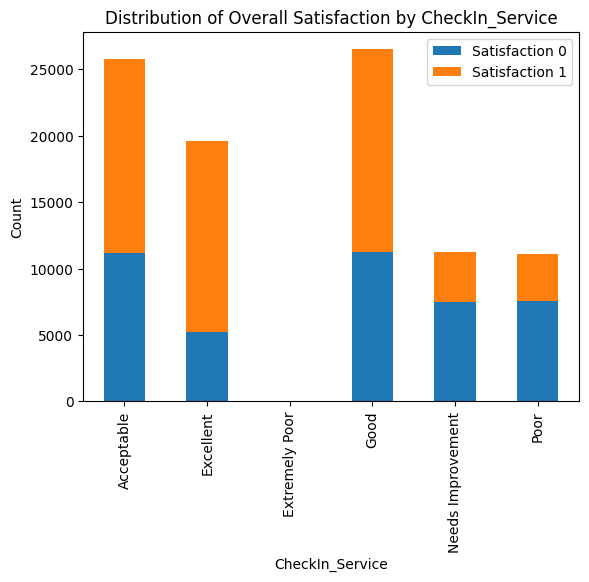

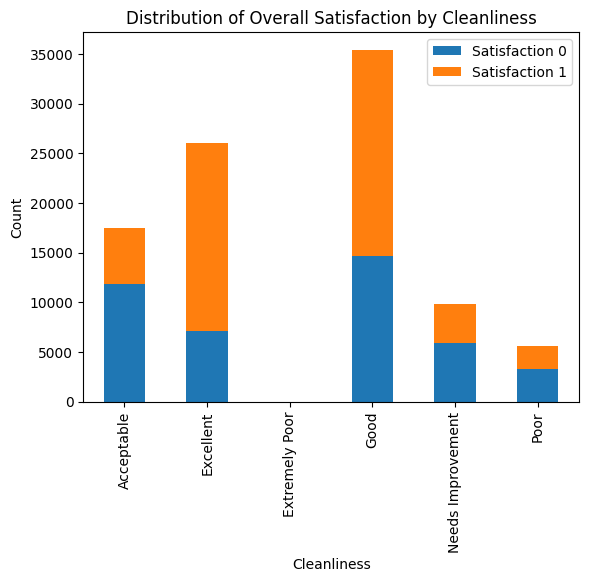

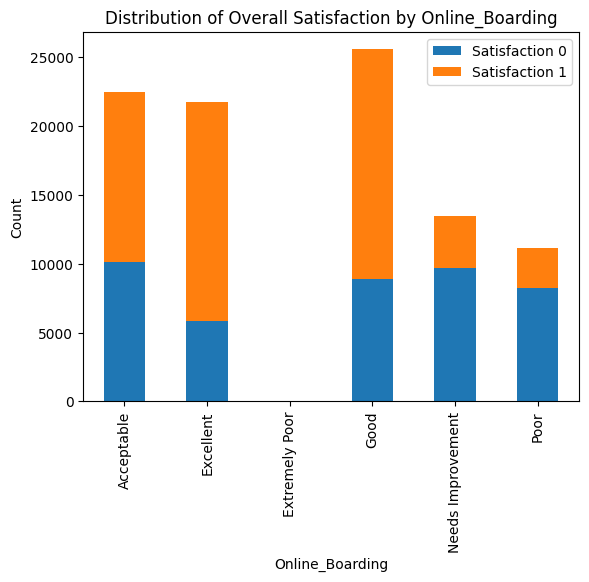

In [9]:
#for column in categorical:
  #train_data[column].value_counts().plot(kind='bar')
  #plt.show()


for column in categorical:
    counts = train_data.groupby(column)['Overall_Experience'].value_counts().unstack().fillna(0)
    counts.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
    plt.title(f'Distribution of Overall Satisfaction by {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(['Satisfaction 0', 'Satisfaction 1'])
    plt.show()

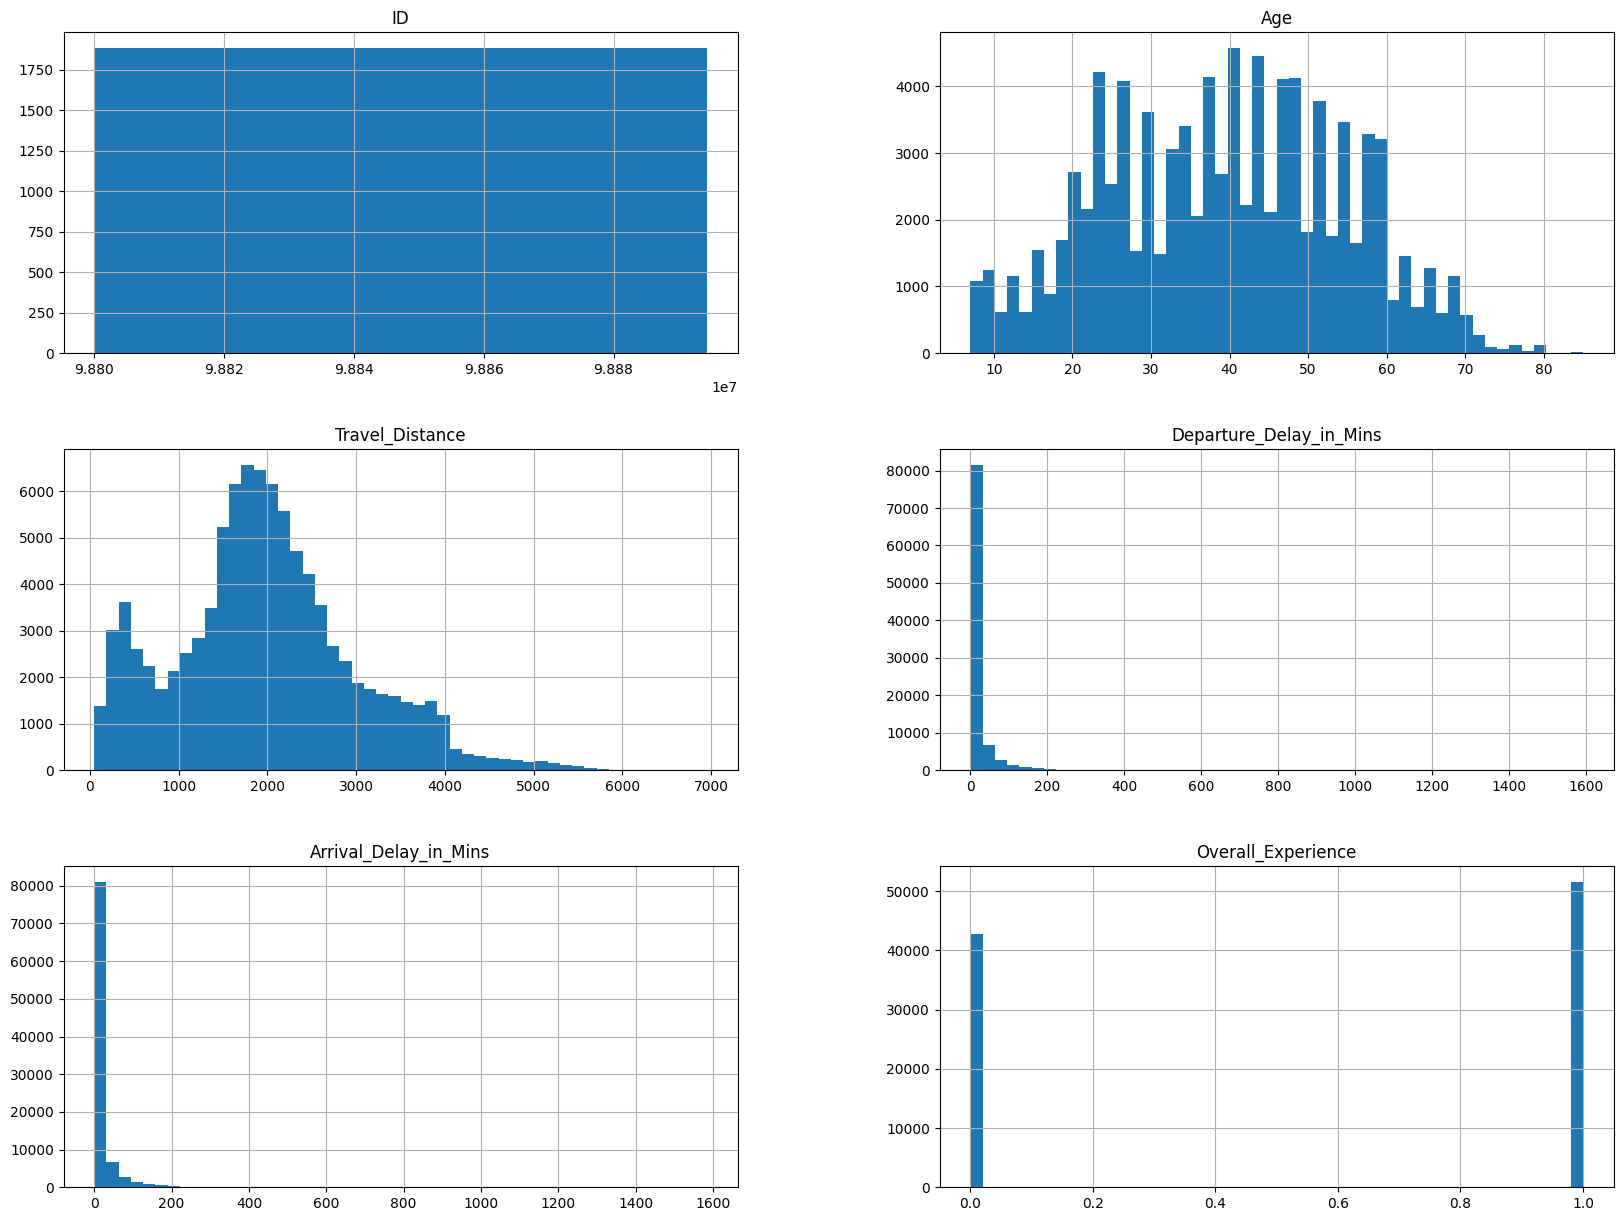

In [11]:
train_data.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
#Total Delay Time
train_data['Total_Delay_Time'] = train_data['Departure_Delay_in_Mins'] + train_data['Arrival_Delay_in_Mins']
test_data['Total_Delay_Time'] = test_data['Departure_Delay_in_Mins'] + test_data['Arrival_Delay_in_Mins']

train_data = train_data.drop(['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'], axis=1)
test_data = test_data.drop(['Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'], axis=1)

In [13]:
train_data = train_data.drop(['Seat_Class', 'Onboard_Wifi_Service', 'Platform_Location'], axis=1)
test_data = test_data.drop(['Seat_Class', 'Onboard_Wifi_Service', 'Platform_Location'], axis=1)

In [14]:
train_data.isnull().sum()

,0
ID,0
Gender,77
Customer_Type,8951
Age,33
Type_Travel,9226
Travel_Class,0
Travel_Distance,0
Overall_Experience,0
Seat_Comfort,61
Arrival_Time_Convenient,8930


### **Data Preprocessing**

In [15]:
numerical_cols = test_data.select_dtypes(include=['int64', 'float64']).columns
num_imputer = SimpleImputer(strategy='mean')
train_data[numerical_cols] = num_imputer.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = num_imputer.transform(test_data[numerical_cols])

In [16]:
categorical_cols = train_data.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_cols] = cat_imputer.fit_transform(train_data[categorical_cols])
test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

In [ ]:
#from sklearn.impute import KNNImputer
#numerical_cols = test_data.select_dtypes(include=['int64', 'float64']).columns
#categorical_cols = train_data.select_dtypes(include=['object']).columns

#num_imputer = KNNImputer(n_neighbors=5)
#train_data[numerical_cols] = num_imputer.fit_transform(train_data[numerical_cols])
#test_data[numerical_cols] = num_imputer.transform(test_data[numerical_cols])

#train_data_cat = train_data[categorical_cols].apply(lambda x: x.astype('category').cat.codes)
#test_data_cat = test_data[categorical_cols].apply(lambda x: x.astype('category').cat.codes)

#cat_imputer = KNNImputer(n_neighbors=5)
#train_data_cat = cat_imputer.fit_transform(train_data_cat)
#test_data_cat = cat_imputer.transform(test_data_cat)

In [17]:
test_data.isnull().sum()

,0
ID,0
Gender,0
Customer_Type,0
Age,0
Type_Travel,0
Travel_Class,0
Travel_Distance,0
Seat_Comfort,0
Arrival_Time_Convenient,0
Catering,0


In [18]:
for column in train_data.select_dtypes(include=['object']):
  le = LabelEncoder()
  train_data[column] = le.fit_transform(train_data[column])

for column in test_data.select_dtypes(include=['object']):
  le = LabelEncoder()
  test_data[column] = le.fit_transform(test_data[column])

### **Train Data**

In [19]:
X = train_data.drop('Overall_Experience', axis=1) # Features
y = train_data['Overall_Experience']  # Target

In [20]:
X_train, X_intermediate, y_train, y_intermediate = train_test_split(X, y, test_size=0.4, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=42)

In [24]:
xgb_model = XGBClassifier()

param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification tasks
    eval_metric='logloss'         # Logarithmic loss for binary classification
)

#random_search = RandomizedSearchCV(
    #estimator=xgb_model,
    #param_distributions=param_distributions,
    #n_iter=30,                   # Number of parameter settings sampled
    #scoring='accuracy',           # Evaluation metric
    #n_jobs=-1,                    # Use all available cores
    #cv=3,                         # Number of cross-validation folds
    #verbose=2,                    # Print progress messages
    #random_state=42               # Seed for reproducibility
#)

#xgb_model = xgb.XGBClassifier(
    #objective='binary:logistic',  # For binary classification tasks
    #eval_metric='logloss',        # Logarithmic loss for binary classification
    #n_estimators=100,             # Number of boosting rounds
    #learning_rate=0.1,            # Step size shrinkage
    #max_depth=6,                  # Maximum depth of a tree
    #min_child_weight=1,           # Minimum sum of instance weight (hessian) needed in a child
    #subsample=0.8,                # Fraction of samples used to build each tree
    #colsample_bytree=0.8          # Fraction of features used to build each tree
#)

#xgb_model.fit(X_train, y_train)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_pred_test1 = best_model.predict(X_test1)
y_pred_test2 = best_model.predict(X_test2)

#y_pred_test1 = xg_reg.predict(X_test1)
#y_pred_test2 = xg_reg.predict(X_test2)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


### **Test Data**

In [25]:
X_test = test_data
y_pred_test = best_model.predict(X_test)
#y_pred_test = xgb_model.predict(X_test)

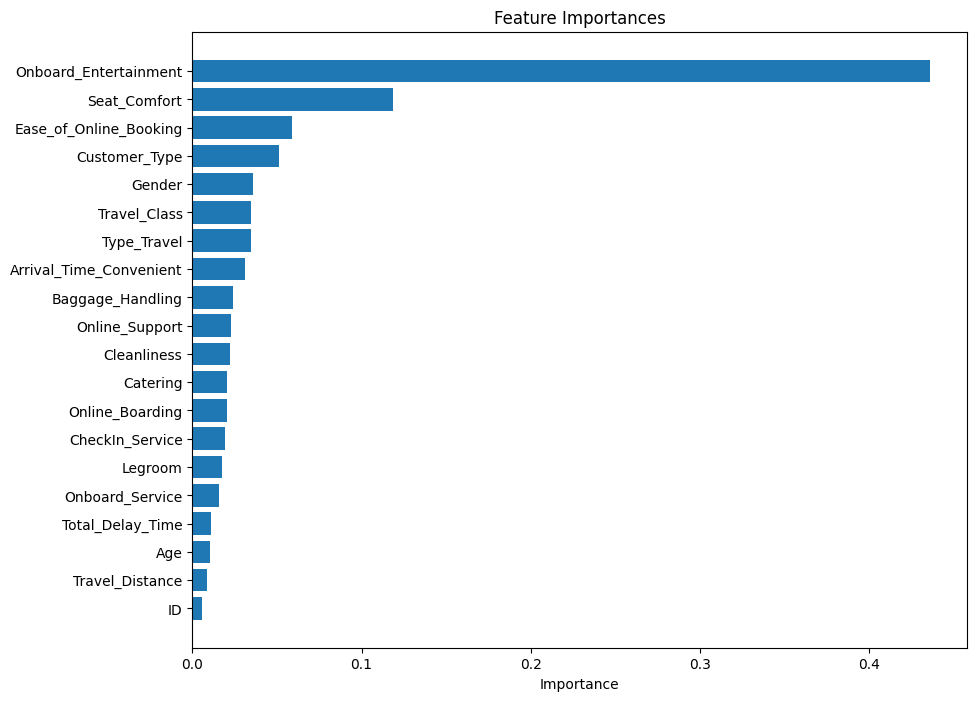

In [31]:
importances = best_model.feature_importances_
feature_names = X_test.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### **Export CSV - Method 1**

In [26]:
output = pd.DataFrame({'ID': test_data['ID'], 'Overall_Experience': y_pred_test})

In [27]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35602 entries, 0 to 35601
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  35602 non-null  float64
 1   Overall_Experience  35602 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 556.4 KB


In [28]:
experience_counts = output['Overall_Experience'].value_counts(normalize=True) * 100
print("Percentage of 0's:", experience_counts.get(0, 0))
print("Percentage of 1's:", experience_counts.get(1, 0))

Percentage of 0's: 45.590135385652495
Percentage of 1's: 54.40986461434751


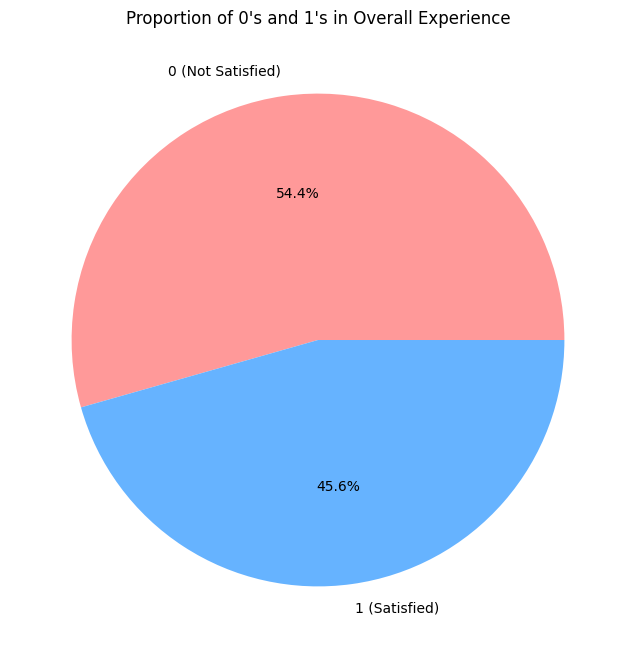

In [29]:
plt.figure(figsize=(8, 8))
plt.pie(experience_counts, labels=['0 (Not Satisfied)', '1 (Satisfied)'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Proportion of 0\'s and 1\'s in Overall Experience')
plt.show()

In [ ]:
output.to_csv('Hackathon_submission_SarahPark.csv', index=False)

In [ ]:
from google.colab import files
files.download('Hackathon_submission_SarahPark.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Export CSV - Method 2**

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Classes/MIT/ADSP/Hackathon/Sample_Submission_(2).csv')

y_pred_test_series = pd.Series(y_pred_test)

if len(y_pred_test_series) != len(sample_submission):
    raise ValueError("The length of y_pred_test does not match the number of rows in sample_submission.")

sample_submission['Overall_Experience'] = y_pred_test_series

In [ ]:
from google.colab import files

sample_submission.to_csv('hackathon_submission.csv', index=False)

files.download('hackathon_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>